In [ ]:
# Voxel-Based Cone-Casting Shadow Attenuation Matrix Generator
#
# This script implements an advanced framework to simulate light attenuation
# using a cone-casting method to account for the sun's angular diameter,
# producing more realistic soft shadows (penumbra).
#
# This version is configured to analyze a single point at the center of the LiDAR scene
# and supports multiple vegetation classes with distinct attenuation coefficients.
#
# NOTE: This version has been simplified to run sequentially without Numba or
# multiprocessing to ensure stability and ease of debugging. Performance will be
# significantly lower than optimized versions.
#
# The pipeline is as follows:
# 1. Data Ingestion: Reads and filters classified LiDAR data (.las/.laz).
# 2. Voxelization: Converts the point cloud into a 3D voxel grid.
# 3. Iterative Cone-Casting: For each solar position, it generates a cone of
#    rays representing the sun's disk.
# 4. Attenuation Modeling: For each ray in the cone, it calculates transmittance
#    based on binary occlusion (buildings) or the Beer-Lambert law (vegetation),
#    using class-specific extinction coefficients.
# 5. Output Generation: The final transmittance for a solar position is the
#    average of all rays in the cone. These values are aggregated into a
#    2D matrix and saved as a CSV file.
#
# Key Libraries:
# - laspy: For reading LiDAR files.
# - numpy: For numerical operations and data structures.
# - pandas: For creating and exporting the final CSV data matrix.

import os
import time
import math

import laspy
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
# Set all simulation parameters in this section.

# 1. Input Data and Scene Definition
LIDAR_FILE_PATH = 'data/houselas_re_veg_2.las'
OUTPUT_DIRECTORY = 'results/shadow_matrix_results'
OUTPUT_FILENAME = 'shadow_attenuation_matrix_conecasting.csv'
BOUNDING_BOX = None

# ASPRS Standard Classification Codes
# Including multiple vegetation classes (3: Low, 4: Medium, 5: High)
RELEVANT_CLASSES = {2, 3, 4, 5, 6}
GROUND_CLASS_CODE = 2
BUILDING_CLASS_CODE = 6
VEGETATION_CLASS_CODES = {3, 4, 5}

# Priority for voxel classification (higher number = higher priority)
# High vegetation (5) has priority over medium (4), etc.
CLASS_PRIORITY = {6: 4, 5: 3, 4: 2, 3: 1, 2: 0, 0: -1}

# 2. Voxelization Parameters
VOXEL_SIZE = 0.5

# 3. Solar Position & Cone-Casting Simulation Parameters
AZIMUTH_STEPS = 360  # 1-degree steps
ELEVATION_STEPS = 91 # 1-degree steps (0-90 inclusive)

# --- NEW: Cone-Casting Parameters ---
# The sun's angular radius is approx 0.265 degrees.
SOLAR_ANGULAR_RADIUS_DEG = 0.265
# Number of rays to cast to approximate the solar disk. More rays = more
# accurate penumbra but longer computation time.
NUM_RAYS_PER_CONE = 16

# 4. Ray-Casting and Attenuation Parameters
# --- UPDATED: Class-specific extinction coefficients ---
# Assign a different base extinction coefficient (k) to each vegetation class.
# These values may need to be calibrated for specific vegetation types.
VEGETATION_EXTINCTION_COEFFICIENTS = {
    3: 0.7,  # k for Low Vegetation
    4: 0.5,  # k for Medium Vegetation
    5: 0.3   # k for High Vegetation
}


# --- MODULE 1: DATA INGESTOR & PREPARER ---

def load_and_prepare_lidar(file_path, bounding_box=None, relevant_classes=None):
    """
    Reads a LAS/LAZ file, filters points by classification and bounding box.
    """
    print(f"Loading LiDAR data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None
    try:
        las = laspy.read(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    points_xyz = np.vstack((las.x, las.y, las.z)).transpose()
    classifications = np.array(las.classification)

    mask = np.ones(len(points_xyz), dtype=bool)
    if bounding_box:
        mask &= (
            (points_xyz[:, 0] >= bounding_box['X_MIN']) & (points_xyz[:, 0] < bounding_box['X_MAX']) &
            (points_xyz[:, 1] >= bounding_box['Y_MIN']) & (points_xyz[:, 1] < bounding_box['Y_MAX'])
        )
    if relevant_classes:
        mask &= np.isin(classifications, list(relevant_classes))

    filtered_points = points_xyz[mask]
    filtered_classifications = classifications[mask]

    if len(filtered_points) == 0:
        print("Warning: No points remaining after filtering.")
        return None, None
    print(f"Data loaded and filtered. {len(filtered_points)} points remaining.")
    return filtered_points, filtered_classifications


# --- MODULE 2: VOXELIZER ---

def voxelize_scene(points, classifications, voxel_size):
    """
    Converts a point cloud into classification and density voxel grids.
    """
    if points is None or len(points) == 0:
        return None, None, None, None

    print("Voxelizing the scene...")
    scene_min = np.min(points, axis=0)
    scene_max = np.max(points, axis=0)
    grid_dims = np.ceil((scene_max - scene_min) / voxel_size).astype(int)
    print(f"Voxel grid dimensions: {grid_dims}")

    classification_grid = np.zeros(grid_dims, dtype=np.int8)
    density_grid = np.zeros(grid_dims, dtype=np.float32)

    voxel_indices = np.floor((points - scene_min) / voxel_size).astype(int)
    for i in range(3):
        voxel_indices[:, i] = np.clip(voxel_indices[:, i], 0, grid_dims[i] - 1)

    print("Populating classification and density grids...")
    for i in range(len(points)):
        idx = tuple(voxel_indices[i])
        current_class = classifications[i]
        if CLASS_PRIORITY.get(current_class, -1) > CLASS_PRIORITY.get(classification_grid[idx], -1):
            classification_grid[idx] = current_class
        if current_class in VEGETATION_CLASS_CODES:
            density_grid[idx] += 1

    voxel_volume = voxel_size ** 3
    vegetation_voxels = np.isin(classification_grid, list(VEGETATION_CLASS_CODES))
    density_grid[vegetation_voxels] /= voxel_volume
    
    print("Voxelization complete.")
    return classification_grid, density_grid, scene_min, grid_dims


# --- MODULE 3: RAY-CASTING & CONE-CASTING ENGINE ---

def generate_cone_vectors(center_direction, radius_rad, num_samples):
    """
    Generates a set of vectors distributed within a cone around a center direction.
    """
    # Create a basis (a coordinate system) aligned with the center_direction
    if np.allclose(np.abs(center_direction), [0, 0, 1]):
        # Handle case where direction is along Z-axis
        v_up = np.array([0, 1, 0])
    else:
        v_up = np.array([0, 0, 1])
    
    u = np.cross(v_up, center_direction)
    u /= np.linalg.norm(u)
    v = np.cross(center_direction, u)

    cone_vectors = []
    # Use stratified sampling for better distribution
    for i in range(num_samples):
        # Sample radius and angle to get points on a disk
        r = radius_rad * np.sqrt((i + 0.5) / num_samples)
        theta = 2 * np.pi * 0.61803398875 * i # Golden angle for good distribution

        # Map disk point to 3D offset and add to center direction
        offset_vec = r * (np.cos(theta) * u + np.sin(theta) * v)
        new_vec = center_direction + offset_vec
        new_vec /= np.linalg.norm(new_vec) # Re-normalize
        cone_vectors.append(new_vec)
        
    return cone_vectors

def trace_ray_fast(ray_origin, ray_direction, scene_min, voxel_size, grid_dims):
    """
    An efficient voxel traversal algorithm (Amanatides-Woo).
    """
    ray_pos = (ray_origin - scene_min) / voxel_size
    ix, iy, iz = int(ray_pos[0]), int(ray_pos[1]), int(ray_pos[2])
    step_x = 1 if ray_direction[0] >= 0 else -1
    step_y = 1 if ray_direction[1] >= 0 else -1
    step_z = 1 if ray_direction[2] >= 0 else -1
    
    next_voxel_boundary_x = (ix + (step_x > 0)) * voxel_size + scene_min[0]
    next_voxel_boundary_y = (iy + (step_y > 0)) * voxel_size + scene_min[1]
    next_voxel_boundary_z = (iz + (step_z > 0)) * voxel_size + scene_min[2]
    
    t_max_x = (next_voxel_boundary_x - ray_origin[0]) / ray_direction[0] if ray_direction[0] != 0 else float('inf')
    t_max_y = (next_voxel_boundary_y - ray_origin[1]) / ray_direction[1] if ray_direction[1] != 0 else float('inf')
    t_max_z = (next_voxel_boundary_z - ray_origin[2]) / ray_direction[2] if ray_direction[2] != 0 else float('inf')
    
    t_delta_x = voxel_size / abs(ray_direction[0]) if ray_direction[0] != 0 else float('inf')
    t_delta_y = voxel_size / abs(ray_direction[1]) if ray_direction[1] != 0 else float('inf')
    t_delta_z = voxel_size / abs(ray_direction[2]) if ray_direction[2] != 0 else float('inf')

    while True:
        if not (0 <= ix < grid_dims[0] and 0 <= iy < grid_dims[1] and 0 <= iz < grid_dims[2]):
            break
        yield (ix, iy, iz)
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                ix += step_x; t_max_x += t_delta_x
            else:
                iz += step_z; t_max_z += t_delta_z
        else:
            if t_max_y < t_max_z:
                iy += step_y; t_max_y += t_delta_y
            else:
                iz += step_z; t_max_z += t_delta_z

def calculate_transmittance(voxel_path_generator, classification_grid, density_grid, voxel_size, k_coeffs):
    """
    Calculates the final transmittance for a single ray path, using class-specific
    extinction coefficients for different vegetation types.
    """
    transmittance = 1.0
    path_length_in_voxel = voxel_size
    for ix, iy, iz in voxel_path_generator:
        voxel_class = classification_grid[ix, iy, iz]
        if voxel_class == BUILDING_CLASS_CODE: return 0.0
        
        # Check if the voxel is any type of vegetation
        if voxel_class in VEGETATION_CLASS_CODES:
            k_base = k_coeffs.get(voxel_class, 0.0) # Look up the correct k
            if k_base > 0:
                density = density_grid[ix, iy, iz]
                if density > 0:
                    k = k_base * density
                    transmittance *= math.exp(-k * path_length_in_voxel)
        
        if transmittance < 1e-6: return 0.0
    return transmittance


# --- MAIN EXECUTION ---

if __name__ == '__main__':
    start_time = time.time()
    
    # 1. Load and Prepare Data
    points, classifications = load_and_prepare_lidar(
        LIDAR_FILE_PATH, BOUNDING_BOX, RELEVANT_CLASSES
    )
    if points is None: exit()

    # 2. Voxelize Scene
    classification_grid, density_grid, scene_min, grid_dims = voxelize_scene(
        points, classifications, VOXEL_SIZE
    )
    if classification_grid is None: exit()
    scene_max = scene_min + grid_dims * VOXEL_SIZE

    # 3. Define the single analysis point at the center of the scene
    scene_center_x = (scene_min[0] + scene_max[0]) / 2
    scene_center_y = (scene_min[1] + scene_max[1]) / 2

    ground_points_all = points[classifications == GROUND_CLASS_CODE]
    if len(ground_points_all) > 0:
        search_radius = 5.0
        center_points_mask = (
            (ground_points_all[:, 0] > scene_center_x - search_radius) &
            (ground_points_all[:, 0] < scene_center_x + search_radius) &
            (ground_points_all[:, 1] > scene_center_y - search_radius) &
            (ground_points_all[:, 1] < scene_center_y + search_radius)
        )
        ground_points_near_center = ground_points_all[center_points_mask]
        if len(ground_points_near_center) > 0:
            ground_z = np.min(ground_points_near_center[:, 2]) + 0.01
        else:
            print("Warning: No ground points near center. Using scene minimum Z.")
            ground_z = scene_min[2] + 0.01
    else:
        print("Warning: No ground points in dataset. Using scene minimum Z.")
        ground_z = scene_min[2] + 0.01

    analysis_point = np.array([scene_center_x, scene_center_y, ground_z])
    print(f"Analysis point set to scene center: {analysis_point}")

    # 4. Define Solar Angles and Run Simulation Loop (SEQUENTIAL)
    azimuths = np.linspace(0, 2 * np.pi, AZIMUTH_STEPS, endpoint=False)
    elevations = np.linspace(0, np.pi / 2, ELEVATION_STEPS, endpoint=True)
    solar_radius_rad = np.deg2rad(SOLAR_ANGULAR_RADIUS_DEG)
    
    simulation_results = []
    
    total_directions = len(azimuths) * (len(elevations) - 1)
    print(f"\n--- Starting SEQUENTIAL Cone-Casting Simulation ---")
    print(f"Casting {NUM_RAYS_PER_CONE} rays per cone for each of {total_directions} solar positions...")
    
    current_direction = 0
    for el in elevations:
        if el < 0.001: continue
        
        for az in azimuths:
            current_direction += 1
            if current_direction % 500 == 0:
                 print(f"Processing direction {current_direction} of {total_directions} (Az: {np.rad2deg(az):.1f}°, El: {np.rad2deg(el):.1f}°)...")
            
            center_ray_direction = np.array([np.cos(el) * np.sin(az), np.cos(el) * np.cos(az), np.sin(el)])
            
            cone_ray_vectors = generate_cone_vectors(center_ray_direction, solar_radius_rad, NUM_RAYS_PER_CONE)
            
            cone_transmittances = []
            for ray_vec in cone_ray_vectors:
                voxel_size = VOXEL_SIZE
                voxel_path_gen = trace_ray_fast(analysis_point, ray_vec, scene_min, voxel_size, grid_dims)
                transmittance = calculate_transmittance(
                    voxel_path_gen, classification_grid, density_grid, voxel_size, VEGETATION_EXTINCTION_COEFFICIENTS
                )
                cone_transmittances.append(transmittance)
            
            avg_transmittance = np.mean(cone_transmittances)
            
            simulation_results.append({
                'azimuth': az, 'elevation': el, 'transmittance': avg_transmittance
            })

    # 5. Format and Save Final Attenuation Matrix
    print("\n--- Aggregating Results into CSV Matrix ---")
    if not simulation_results:
        print("No results to save. Exiting.")
        exit()

    df = pd.DataFrame(simulation_results)
    df['azimuth_deg'] = np.round(np.rad2deg(df['azimuth'])).astype(int)
    df['elevation_deg'] = np.round(np.rad2deg(df['elevation'])).astype(int)
    
    shadow_matrix_df = df.pivot_table(
        index='elevation_deg', columns='azimuth_deg', values='transmittance'
    )
    
    shadow_matrix_df.index = [f"Altitude_{i}" for i in shadow_matrix_df.index]
    shadow_matrix_df.columns = [f"Azimuth_{c}" for c in shadow_matrix_df.columns]
    
    shadow_matrix_df = shadow_matrix_df.sort_index(key=lambda x: np.array([int(i.split('_')[1]) for i in x]))
    shadow_matrix_df = shadow_matrix_df.sort_index(axis=1, key=lambda x: np.array([int(i.split('_')[1]) for i in x]))

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)
        
    output_path = os.path.join(OUTPUT_DIRECTORY, OUTPUT_FILENAME)
    shadow_matrix_df.to_csv(output_path, header=True, index=True)
    
    end_time = time.time()
    print(f"\n--- Simulation Finished ---")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")
    print(f"Saved shadow attenuation matrix to {output_path}")



In [ ]:
# Voxel-Based Cone-Casting Shadow Attenuation Matrix Generator
#
# This script implements an advanced framework to simulate light attenuation
# using a cone-casting method to account for the sun's angular diameter,
# producing more realistic soft shadows (penumbra).
#
# This version is configured to analyze a single point at the center of the LiDAR scene
# and supports multiple vegetation classes with distinct attenuation coefficients.
#
# NOTE: This version has been simplified to run sequentially without Numba or
# multiprocessing to ensure stability and ease of debugging. Performance will be
# significantly lower than optimized versions.
#
# The pipeline is as follows:
# 1. Data Ingestion: Reads and filters classified LiDAR data (.las/.laz).
# 2. Voxelization: Converts the point cloud into a 3D voxel grid.
# 3. Building Extrusion: Fills voxels below building roof points to create solid structures.
# 4. Iterative Cone-Casting: For each solar position, it generates a cone of
#    rays representing the sun's disk.
# 5. Attenuation Modeling: For each ray in the cone, it calculates transmittance
#    based on binary occlusion (buildings) or the Beer-Lambert law (vegetation),
#    using class-specific extinction coefficients.
# 6. Output Generation: The final transmittance for a solar position is the
#    average of all rays in the cone. These values are aggregated into a
#    2D matrix and saved as a CSV file.
#
# Key Libraries:
# - laspy: For reading LiDAR files.
# - numpy: For numerical operations and data structures.
# - pandas: For creating and exporting the final CSV data matrix.

import os
import time
import math

import laspy
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
# Set all simulation parameters in this section.

# 1. Input Data and Scene Definition
LIDAR_FILE_PATH = 'data/houselas_re_veg_2.las'
OUTPUT_DIRECTORY = 'results/shadow_matrix_results'
OUTPUT_FILENAME = 'shadow_attenuation_matrix_conecasting.csv'
BOUNDING_BOX = None

# --- NEW: Specific target coordinates for analysis ---
TARGET_COORDS_2D = np.array([532886, 6983516])

# ASPRS Standard Classification Codes
# Including multiple vegetation classes (3: Low, 4: Medium, 5: High)
RELEVANT_CLASSES = {2, 3, 4, 5, 6}
GROUND_CLASS_CODE = 2
BUILDING_CLASS_CODE = 6
VEGETATION_CLASS_CODES = {3, 4, 5}

# Priority for voxel classification (higher number = higher priority)
# High vegetation (5) has priority over medium (4), etc.
CLASS_PRIORITY = {6: 4, 5: 3, 4: 2, 3: 1, 2: 0, 0: -1}

# 2. Voxelization Parameters
VOXEL_SIZE = 0.5

# 3. Solar Position & Cone-Casting Simulation Parameters
AZIMUTH_STEPS = 360  # 1-degree steps
ELEVATION_STEPS = 91 # 1-degree steps (0-90 inclusive)

# --- NEW: Cone-Casting Parameters ---
# The sun's angular radius is approx 0.265 degrees.
SOLAR_ANGULAR_RADIUS_DEG = 0.265
# Number of rays to cast to approximate the solar disk. More rays = more
# accurate penumbra but longer computation time.
NUM_RAYS_PER_CONE = 16

# 4. Ray-Casting and Attenuation Parameters
# --- UPDATED: Class-specific extinction coefficients ---
# Assign a different base extinction coefficient (k) to each vegetation class.
# These values may need to be calibrated for specific vegetation types.
VEGETATION_EXTINCTION_COEFFICIENTS = {
    3: 0.7,  # k for Low Vegetation
    4: 0.5,  # k for Medium Vegetation
    5: 0.3   # k for High Vegetation
}


# --- MODULE 1: DATA INGESTOR & PREPARER ---

def load_and_prepare_lidar(file_path, bounding_box=None, relevant_classes=None):
    """
    Reads a LAS/LAZ file, filters points by classification and bounding box.
    """
    print(f"Loading LiDAR data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None
    try:
        las = laspy.read(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    points_xyz = np.vstack((las.x, las.y, las.z)).transpose()
    classifications = np.array(las.classification)

    mask = np.ones(len(points_xyz), dtype=bool)
    if bounding_box:
        mask &= (
            (points_xyz[:, 0] >= bounding_box['X_MIN']) & (points_xyz[:, 0] < bounding_box['X_MAX']) &
            (points_xyz[:, 1] >= bounding_box['Y_MIN']) & (points_xyz[:, 1] < bounding_box['Y_MAX'])
        )
    if relevant_classes:
        mask &= np.isin(classifications, list(relevant_classes))

    filtered_points = points_xyz[mask]
    filtered_classifications = classifications[mask]

    if len(filtered_points) == 0:
        print("Warning: No points remaining after filtering.")
        return None, None
    print(f"Data loaded and filtered. {len(filtered_points)} points remaining.")
    return filtered_points, filtered_classifications


# --- MODULE 2: VOXELIZER ---

def voxelize_scene(points, classifications, voxel_size):
    """
    Converts a point cloud into classification and density voxel grids.
    """
    if points is None or len(points) == 0:
        return None, None, None, None

    print("Voxelizing the scene...")
    scene_min = np.min(points, axis=0)
    scene_max = np.max(points, axis=0)
    grid_dims = np.ceil((scene_max - scene_min) / voxel_size).astype(int)
    print(f"Voxel grid dimensions: {grid_dims}")

    classification_grid = np.zeros(grid_dims, dtype=np.int8)
    density_grid = np.zeros(grid_dims, dtype=np.float32)

    voxel_indices = np.floor((points - scene_min) / voxel_size).astype(int)
    for i in range(3):
        voxel_indices[:, i] = np.clip(voxel_indices[:, i], 0, grid_dims[i] - 1)

    print("Populating classification and density grids from points...")
    for i in range(len(points)):
        idx = tuple(voxel_indices[i])
        current_class = classifications[i]
        if CLASS_PRIORITY.get(current_class, -1) > CLASS_PRIORITY.get(classification_grid[idx], -1):
            classification_grid[idx] = current_class
        if current_class in VEGETATION_CLASS_CODES:
            density_grid[idx] += 1

    voxel_volume = voxel_size ** 3
    vegetation_voxels = np.isin(classification_grid, list(VEGETATION_CLASS_CODES))
    density_grid[vegetation_voxels] /= voxel_volume
    
    print("Voxelization complete.")
    return classification_grid, density_grid, scene_min, grid_dims


# --- MODULE 3: RAY-CASTING & CONE-CASTING ENGINE ---

def generate_cone_vectors(center_direction, radius_rad, num_samples):
    """
    Generates a set of vectors distributed within a cone around a center direction.
    """
    # Create a basis (a coordinate system) aligned with the center_direction
    if np.allclose(np.abs(center_direction), [0, 0, 1]):
        # Handle case where direction is along Z-axis
        v_up = np.array([0, 1, 0])
    else:
        v_up = np.array([0, 0, 1])
    
    u = np.cross(v_up, center_direction)
    u /= np.linalg.norm(u)
    v = np.cross(center_direction, u)

    cone_vectors = []
    # Use stratified sampling for better distribution
    for i in range(num_samples):
        # Sample radius and angle to get points on a disk
        r = radius_rad * np.sqrt((i + 0.5) / num_samples)
        theta = 2 * np.pi * 0.61803398875 * i # Golden angle for good distribution

        # Map disk point to 3D offset and add to center direction
        offset_vec = r * (np.cos(theta) * u + np.sin(theta) * v)
        new_vec = center_direction + offset_vec
        new_vec /= np.linalg.norm(new_vec) # Re-normalize
        cone_vectors.append(new_vec)
        
    return cone_vectors

def trace_ray_fast(ray_origin, ray_direction, scene_min, voxel_size, grid_dims):
    """
    An efficient voxel traversal algorithm (Amanatides-Woo).
    """
    ray_pos = (ray_origin - scene_min) / voxel_size
    ix, iy, iz = int(ray_pos[0]), int(ray_pos[1]), int(ray_pos[2])
    step_x = 1 if ray_direction[0] >= 0 else -1
    step_y = 1 if ray_direction[1] >= 0 else -1
    step_z = 1 if ray_direction[2] >= 0 else -1
    
    next_voxel_boundary_x = (ix + (step_x > 0)) * voxel_size + scene_min[0]
    next_voxel_boundary_y = (iy + (step_y > 0)) * voxel_size + scene_min[1]
    next_voxel_boundary_z = (iz + (step_z > 0)) * voxel_size + scene_min[2]
    
    t_max_x = (next_voxel_boundary_x - ray_origin[0]) / ray_direction[0] if ray_direction[0] != 0 else float('inf')
    t_max_y = (next_voxel_boundary_y - ray_origin[1]) / ray_direction[1] if ray_direction[1] != 0 else float('inf')
    t_max_z = (next_voxel_boundary_z - ray_origin[2]) / ray_direction[2] if ray_direction[2] != 0 else float('inf')
    
    t_delta_x = voxel_size / abs(ray_direction[0]) if ray_direction[0] != 0 else float('inf')
    t_delta_y = voxel_size / abs(ray_direction[1]) if ray_direction[1] != 0 else float('inf')
    t_delta_z = voxel_size / abs(ray_direction[2]) if ray_direction[2] != 0 else float('inf')

    while True:
        if not (0 <= ix < grid_dims[0] and 0 <= iy < grid_dims[1] and 0 <= iz < grid_dims[2]):
            break
        yield (ix, iy, iz)
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                ix += step_x; t_max_x += t_delta_x
            else:
                iz += step_z; t_max_z += t_delta_z
        else:
            if t_max_y < t_max_z:
                iy += step_y; t_max_y += t_delta_y
            else:
                iz += step_z; t_max_z += t_delta_z

def calculate_transmittance(voxel_path_generator, classification_grid, density_grid, voxel_size, k_coeffs):
    """
    Calculates the final transmittance for a single ray path, using class-specific
    extinction coefficients for different vegetation types.
    """
    transmittance = 1.0
    path_length_in_voxel = voxel_size
    for ix, iy, iz in voxel_path_generator:
        voxel_class = classification_grid[ix, iy, iz]
        if voxel_class == BUILDING_CLASS_CODE: return 0.0
        
        # Check if the voxel is any type of vegetation
        if voxel_class in VEGETATION_CLASS_CODES:
            k_base = k_coeffs.get(voxel_class, 0.0) # Look up the correct k
            if k_base > 0:
                density = density_grid[ix, iy, iz]
                if density > 0:
                    k = k_base * density
                    transmittance *= math.exp(-k * path_length_in_voxel)
        
        if transmittance < 1e-6: return 0.0
    return transmittance


# --- MAIN EXECUTION ---

if __name__ == '__main__':
    start_time = time.time()
    
    # 1. Load and Prepare Data
    points, classifications = load_and_prepare_lidar(
        LIDAR_FILE_PATH, BOUNDING_BOX, RELEVANT_CLASSES
    )
    if points is None: exit()

    # 2. Voxelize Scene
    classification_grid, density_grid, scene_min, grid_dims = voxelize_scene(
        points, classifications, VOXEL_SIZE
    )
    if classification_grid is None: exit()
    scene_max = scene_min + grid_dims * VOXEL_SIZE

    # 3. Define the single analysis point using the specified coordinates
    print(f"Using specified target coordinates: {TARGET_COORDS_2D}")

    # Find the Z value for the highest point (e.g., a roof) at the target coordinates.
    search_radius = 5.0 # 5 meters
    points_near_target_mask = (
        (points[:, 0] > TARGET_COORDS_2D[0] - search_radius) &
        (points[:, 0] < TARGET_COORDS_2D[0] + search_radius) &
        (points[:, 1] > TARGET_COORDS_2D[1] - search_radius) &
        (points[:, 1] < TARGET_COORDS_2D[1] + search_radius)
    )
    points_near_target = points[points_near_target_mask]

    if len(points_near_target) > 0:
        # Find the highest Z value in the vicinity of the target
        target_z = np.max(points_near_target[:, 2]) + 0.01
    else:
        print(f"Warning: No LiDAR points found near target coordinates. Using scene maximum Z as a fallback.")
        target_z = scene_max[2]

    analysis_point = np.array([TARGET_COORDS_2D[0], TARGET_COORDS_2D[1], target_z])
    print(f"Analysis point set to: {analysis_point}")

    # 4. Define Solar Angles and Run Simulation Loop (SEQUENTIAL)
    azimuths = np.linspace(0, 2 * np.pi, AZIMUTH_STEPS, endpoint=False)
    elevations = np.linspace(0, np.pi / 2, ELEVATION_STEPS, endpoint=True)
    solar_radius_rad = np.deg2rad(SOLAR_ANGULAR_RADIUS_DEG)
    
    simulation_results = []
    
    total_directions = len(azimuths) * (len(elevations) - 1)
    print(f"\n--- Starting SEQUENTIAL Cone-Casting Simulation ---")
    print(f"Casting {NUM_RAYS_PER_CONE} rays per cone for each of {total_directions} solar positions...")
    
    current_direction = 0
    for el in elevations:
        if el < 0.001: continue
        
        for az in azimuths:
            current_direction += 1
            if current_direction % 500 == 0:
                 print(f"Processing direction {current_direction} of {total_directions} (Az: {np.rad2deg(az):.1f}°, El: {np.rad2deg(el):.1f}°)...")
            
            center_ray_direction = np.array([np.cos(el) * np.sin(az), np.cos(el) * np.cos(az), np.sin(el)])
            
            cone_ray_vectors = generate_cone_vectors(center_ray_direction, solar_radius_rad, NUM_RAYS_PER_CONE)
            
            cone_transmittances = []
            for ray_vec in cone_ray_vectors:
                voxel_path_gen = trace_ray_fast(analysis_point, ray_vec, scene_min, voxel_size, grid_dims)
                transmittance = calculate_transmittance(
                    voxel_path_gen, classification_grid, density_grid, voxel_size, VEGETATION_EXTINCTION_COEFFICIENTS
                )
                cone_transmittances.append(transmittance)
            
            avg_transmittance = np.mean(cone_transmittances)
            
            simulation_results.append({
                'azimuth': az, 'elevation': el, 'transmittance': avg_transmittance
            })

    # 5. Format and Save Final Attenuation Matrix
    print("\n--- Aggregating Results into CSV Matrix ---")
    if not simulation_results:
        print("No results to save. Exiting.")
        exit()

    df = pd.DataFrame(simulation_results)
    df['azimuth_deg'] = np.round(np.rad2deg(df['azimuth'])).astype(int)
    df['elevation_deg'] = np.round(np.rad2deg(df['elevation'])).astype(int)
    
    shadow_matrix_df = df.pivot_table(
        index='elevation_deg', columns='azimuth_deg', values='transmittance'
    )
    
    # Sort the DataFrame by numeric index and columns to ensure correct order
    shadow_matrix_df = shadow_matrix_df.sort_index(axis=0).sort_index(axis=1)

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)
        
    output_path = os.path.join(OUTPUT_DIRECTORY, OUTPUT_FILENAME)
    # Write to CSV without header or index
    shadow_matrix_df.to_csv(output_path, header=False, index=False)
    
    end_time = time.time()
    print(f"\n--- Simulation Finished ---")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")
    print(f"Saved shadow attenuation matrix to {output_path}")

In [ ]:
# Voxel-Based Cone-Casting Shadow Attenuation Matrix Generator
#
# This script implements an advanced framework to simulate light attenuation
# using a cone-casting method to account for the sun's angular diameter,
# producing more realistic soft shadows (penumbra).
#
# This version is configured to analyze a single point at the center of the LiDAR scene
# and supports multiple vegetation classes with distinct attenuation coefficients.
#
# NOTE: This version has been simplified to run sequentially without Numba or
# multiprocessing to ensure stability and ease of debugging. Performance will be
# significantly lower than optimized versions.
#
# The pipeline is as follows:
# 1. Data Ingestion: Reads and filters classified LiDAR data (.las/.laz).
# 2. Voxelization: Converts the point cloud into a 3D voxel grid.
# 3. Building Extrusion: Fills voxels below building roof points to create solid structures.
# 4. Iterative Cone-Casting: For each solar position, it generates a cone of
#    rays representing the sun's disk.
# 5. Attenuation Modeling: For each ray in the cone, it calculates transmittance
#    based on binary occlusion (buildings) or the Beer-Lambert law (vegetation),
#    using class-specific extinction coefficients.
# 6. Output Generation: The final transmittance for a solar position is the
#    average of all rays in the cone. These values are aggregated into a
#    2D matrix and saved as a CSV file.
#
# Key Libraries:
# - laspy: For reading LiDAR files.
# - numpy: For numerical operations and data structures.
# - pandas: For creating and exporting the final CSV data matrix.

import os
import time
import math

import laspy
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
# Set all simulation parameters in this section.

# 1. Input Data and Scene Definition
LIDAR_FILE_PATH = 'data/houselas_re_veg_2.las'
OUTPUT_DIRECTORY = 'results/shadow_matrix_results'
OUTPUT_FILENAME = 'shadow_attenuation_matrix_conecasting.csv'
BOUNDING_BOX = None

# --- NEW: Specific target coordinates for analysis ---
TARGET_COORDS_2D = np.array([532886, 6983516])

# ASPRS Standard Classification Codes
# Including multiple vegetation classes (3: Low, 4: Medium, 5: High)
RELEVANT_CLASSES = {2, 3, 4, 5, 6}
GROUND_CLASS_CODE = 2
BUILDING_CLASS_CODE = 6
VEGETATION_CLASS_CODES = {3, 4, 5}

# Priority for voxel classification (higher number = higher priority)
# High vegetation (5) has priority over medium (4), etc.
CLASS_PRIORITY = {6: 4, 5: 3, 4: 2, 3: 1, 2: 0, 0: -1}

# 2. Voxelization Parameters
VOXEL_SIZE = 0.5

# 3. Solar Position & Cone-Casting Simulation Parameters
AZIMUTH_STEPS = 360  # 1-degree steps
ELEVATION_STEPS = 91 # 1-degree steps (0-90 inclusive)

# --- NEW: Cone-Casting Parameters ---
# The sun's angular radius is approx 0.265 degrees.
SOLAR_ANGULAR_RADIUS_DEG = 0.265
# Number of rays to cast to approximate the solar disk. More rays = more
# accurate penumbra but longer computation time.
NUM_RAYS_PER_CONE = 16

# 4. Ray-Casting and Attenuation Parameters
# --- UPDATED: Class-specific extinction coefficients ---
# Assign a different base extinction coefficient (k) to each vegetation class.
# These values may need to be calibrated for specific vegetation types.
VEGETATION_EXTINCTION_COEFFICIENTS = {
    3: 0.7,  # k for Low Vegetation
    4: 0.5,  # k for Medium Vegetation
    5: 0.3   # k for High Vegetation
}


# --- MODULE 1: DATA INGESTOR & PREPARER ---

def load_and_prepare_lidar(file_path, bounding_box=None, relevant_classes=None):
    """
    Reads a LAS/LAZ file, filters points by classification and bounding box.
    """
    print(f"Loading LiDAR data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None
    try:
        las = laspy.read(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    points_xyz = np.vstack((las.x, las.y, las.z)).transpose()
    classifications = np.array(las.classification)

    mask = np.ones(len(points_xyz), dtype=bool)
    if bounding_box:
        mask &= (
            (points_xyz[:, 0] >= bounding_box['X_MIN']) & (points_xyz[:, 0] < bounding_box['X_MAX']) &
            (points_xyz[:, 1] >= bounding_box['Y_MIN']) & (points_xyz[:, 1] < bounding_box['Y_MAX'])
        )
    if relevant_classes:
        mask &= np.isin(classifications, list(relevant_classes))

    filtered_points = points_xyz[mask]
    filtered_classifications = classifications[mask]

    if len(filtered_points) == 0:
        print("Warning: No points remaining after filtering.")
        return None, None
    print(f"Data loaded and filtered. {len(filtered_points)} points remaining.")
    return filtered_points, filtered_classifications


# --- MODULE 2: VOXELIZER ---

def voxelize_scene(points, classifications, voxel_size):
    """
    Converts a point cloud into classification and density voxel grids.
    Includes a step to extrude building footprints downwards.
    """
    if points is None or len(points) == 0:
        return None, None, None, None

    print("Voxelizing the scene...")
    scene_min = np.min(points, axis=0)
    scene_max = np.max(points, axis=0)
    grid_dims = np.ceil((scene_max - scene_min) / voxel_size).astype(int)
    print(f"Voxel grid dimensions: {grid_dims}")

    classification_grid = np.zeros(grid_dims, dtype=np.int8)
    density_grid = np.zeros(grid_dims, dtype=np.float32)

    voxel_indices = np.floor((points - scene_min) / voxel_size).astype(int)
    for i in range(3):
        voxel_indices[:, i] = np.clip(voxel_indices[:, i], 0, grid_dims[i] - 1)

    print("Populating classification and density grids from points...")
    for i in range(len(points)):
        idx = tuple(voxel_indices[i])
        current_class = classifications[i]
        if CLASS_PRIORITY.get(current_class, -1) > CLASS_PRIORITY.get(classification_grid[idx], -1):
            classification_grid[idx] = current_class
        if current_class in VEGETATION_CLASS_CODES:
            density_grid[idx] += 1

    # --- NEW: Extrude building footprints downwards ---
    print("Extruding building footprints to create solid models...")
    building_indices = np.argwhere(classification_grid == BUILDING_CLASS_CODE)

    for ix, iy, iz in building_indices:
        # Iterate from the voxel below the roof down to the ground level (z=0)
        for z_level in range(iz - 1, -1, -1):
            # Only fill if the voxel below has a lower priority class
            if CLASS_PRIORITY.get(classification_grid[ix, iy, z_level], -1) < CLASS_PRIORITY[BUILDING_CLASS_CODE]:
                classification_grid[ix, iy, z_level] = BUILDING_CLASS_CODE
            else:
                # Stop if we hit something with equal or higher priority (e.g., another building part)
                break
    print("Building extrusion complete.")

    voxel_volume = voxel_size ** 3
    vegetation_voxels = np.isin(classification_grid, list(VEGETATION_CLASS_CODES))
    density_grid[vegetation_voxels] /= voxel_volume
    
    print("Voxelization complete.")
    return classification_grid, density_grid, scene_min, grid_dims


# --- MODULE 3: RAY-CASTING & CONE-CASTING ENGINE ---

def generate_cone_vectors(center_direction, radius_rad, num_samples):
    """
    Generates a set of vectors distributed within a cone around a center direction.
    """
    # Create a basis (a coordinate system) aligned with the center_direction
    if np.allclose(np.abs(center_direction), [0, 0, 1]):
        # Handle case where direction is along Z-axis
        v_up = np.array([0, 1, 0])
    else:
        v_up = np.array([0, 0, 1])
    
    u = np.cross(v_up, center_direction)
    u /= np.linalg.norm(u)
    v = np.cross(center_direction, u)

    cone_vectors = []
    # Use stratified sampling for better distribution
    for i in range(num_samples):
        # Sample radius and angle to get points on a disk
        r = radius_rad * np.sqrt((i + 0.5) / num_samples)
        theta = 2 * np.pi * 0.61803398875 * i # Golden angle for good distribution

        # Map disk point to 3D offset and add to center direction
        offset_vec = r * (np.cos(theta) * u + np.sin(theta) * v)
        new_vec = center_direction + offset_vec
        new_vec /= np.linalg.norm(new_vec) # Re-normalize
        cone_vectors.append(new_vec)
        
    return cone_vectors

def trace_ray_fast(ray_origin, ray_direction, scene_min, voxel_size, grid_dims):
    """
    An efficient voxel traversal algorithm (Amanatides-Woo).
    """
    ray_pos = (ray_origin - scene_min) / voxel_size
    ix, iy, iz = int(ray_pos[0]), int(ray_pos[1]), int(ray_pos[2])
    step_x = 1 if ray_direction[0] >= 0 else -1
    step_y = 1 if ray_direction[1] >= 0 else -1
    step_z = 1 if ray_direction[2] >= 0 else -1
    
    next_voxel_boundary_x = (ix + (step_x > 0)) * voxel_size + scene_min[0]
    next_voxel_boundary_y = (iy + (step_y > 0)) * voxel_size + scene_min[1]
    next_voxel_boundary_z = (iz + (step_z > 0)) * voxel_size + scene_min[2]
    
    t_max_x = (next_voxel_boundary_x - ray_origin[0]) / ray_direction[0] if ray_direction[0] != 0 else float('inf')
    t_max_y = (next_voxel_boundary_y - ray_origin[1]) / ray_direction[1] if ray_direction[1] != 0 else float('inf')
    t_max_z = (next_voxel_boundary_z - ray_origin[2]) / ray_direction[2] if ray_direction[2] != 0 else float('inf')
    
    t_delta_x = voxel_size / abs(ray_direction[0]) if ray_direction[0] != 0 else float('inf')
    t_delta_y = voxel_size / abs(ray_direction[1]) if ray_direction[1] != 0 else float('inf')
    t_delta_z = voxel_size / abs(ray_direction[2]) if ray_direction[2] != 0 else float('inf')

    while True:
        if not (0 <= ix < grid_dims[0] and 0 <= iy < grid_dims[1] and 0 <= iz < grid_dims[2]):
            break
        yield (ix, iy, iz)
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                ix += step_x; t_max_x += t_delta_x
            else:
                iz += step_z; t_max_z += t_delta_z
        else:
            if t_max_y < t_max_z:
                iy += step_y; t_max_y += t_delta_y
            else:
                iz += step_z; t_max_z += t_delta_z

def calculate_transmittance(voxel_path_generator, classification_grid, density_grid, voxel_size, k_coeffs):
    """
    Calculates the final transmittance for a single ray path, using class-specific
    extinction coefficients for different vegetation types.
    """
    transmittance = 1.0
    path_length_in_voxel = voxel_size
    for ix, iy, iz in voxel_path_generator:
        voxel_class = classification_grid[ix, iy, iz]
        if voxel_class == BUILDING_CLASS_CODE: return 0.0
        
        # Check if the voxel is any type of vegetation
        if voxel_class in VEGETATION_CLASS_CODES:
            k_base = k_coeffs.get(voxel_class, 0.0) # Look up the correct k
            if k_base > 0:
                density = density_grid[ix, iy, iz]
                if density > 0:
                    k = k_base * density
                    transmittance *= math.exp(-k * path_length_in_voxel)
        
        if transmittance < 1e-6: return 0.0
    return transmittance


# --- MAIN EXECUTION ---

if __name__ == '__main__':
    start_time = time.time()
    
    # 1. Load and Prepare Data
    points, classifications = load_and_prepare_lidar(
        LIDAR_FILE_PATH, BOUNDING_BOX, RELEVANT_CLASSES
    )
    if points is None: exit()

    # 2. Voxelize Scene
    classification_grid, density_grid, scene_min, grid_dims = voxelize_scene(
        points, classifications, VOXEL_SIZE
    )
    if classification_grid is None: exit()
    scene_max = scene_min + grid_dims * VOXEL_SIZE

    # 3. Define the single analysis point using the specified coordinates
    print(f"Using specified target coordinates: {TARGET_COORDS_2D}")

    # Find the Z value for the highest point (e.g., a roof) at the target coordinates.
    search_radius = 5.0 # 5 meters
    points_near_target_mask = (
        (points[:, 0] > TARGET_COORDS_2D[0] - search_radius) &
        (points[:, 0] < TARGET_COORDS_2D[0] + search_radius) &
        (points[:, 1] > TARGET_COORDS_2D[1] - search_radius) &
        (points[:, 1] < TARGET_COORDS_2D[1] + search_radius)
    )
    points_near_target = points[points_near_target_mask]

    if len(points_near_target) > 0:
        # Find the highest Z value in the vicinity of the target
        target_z = np.max(points_near_target[:, 2]) + 0.01
    else:
        print(f"Warning: No LiDAR points found near target coordinates. Using scene maximum Z as a fallback.")
        target_z = scene_max[2]

    analysis_point = np.array([TARGET_COORDS_2D[0], TARGET_COORDS_2D[1], target_z])
    print(f"Analysis point set to: {analysis_point}")

    # 4. Define Solar Angles and Run Simulation Loop (SEQUENTIAL)
    azimuths = np.linspace(0, 2 * np.pi, AZIMUTH_STEPS, endpoint=False)
    elevations = np.linspace(0, np.pi / 2, ELEVATION_STEPS, endpoint=True)
    solar_radius_rad = np.deg2rad(SOLAR_ANGULAR_RADIUS_DEG)
    
    simulation_results = []
    
    total_directions = len(azimuths) * (len(elevations) - 1)
    print(f"\n--- Starting SEQUENTIAL Cone-Casting Simulation ---")
    print(f"Casting {NUM_RAYS_PER_CONE} rays per cone for each of {total_directions} solar positions...")
    
    current_direction = 0
    for el in elevations:
        if el < 0.001: continue
        
        for az in azimuths:
            current_direction += 1
            if current_direction % 500 == 0:
                 print(f"Processing direction {current_direction} of {total_directions} (Az: {np.rad2deg(az):.1f}°, El: {np.rad2deg(el):.1f}°)...")
            
            center_ray_direction = np.array([np.cos(el) * np.sin(az), np.cos(el) * np.cos(az), np.sin(el)])
            
            cone_ray_vectors = generate_cone_vectors(center_ray_direction, solar_radius_rad, NUM_RAYS_PER_CONE)
            
            cone_transmittances = []
            for ray_vec in cone_ray_vectors:
                voxel_path_gen = trace_ray_fast(analysis_point, ray_vec, scene_min, voxel_size, grid_dims)
                transmittance = calculate_transmittance(
                    voxel_path_gen, classification_grid, density_grid, voxel_size, VEGETATION_EXTINCTION_COEFFICIENTS
                )
                cone_transmittances.append(transmittance)
            
            avg_transmittance = np.mean(cone_transmittances)
            
            simulation_results.append({
                'azimuth': az, 'elevation': el, 'transmittance': avg_transmittance
            })

    # 5. Format and Save Final Attenuation Matrix
    print("\n--- Aggregating Results into CSV Matrix ---")
    if not simulation_results:
        print("No results to save. Exiting.")
        exit()

    df = pd.DataFrame(simulation_results)
    df['azimuth_deg'] = np.round(np.rad2deg(df['azimuth'])).astype(int)
    df['elevation_deg'] = np.round(np.rad2deg(df['elevation'])).astype(int)
    
    shadow_matrix_df = df.pivot_table(
        index='elevation_deg', columns='azimuth_deg', values='transmittance'
    )
    
    # Sort the DataFrame by numeric index and columns to ensure correct order
    shadow_matrix_df = shadow_matrix_df.sort_index(axis=0).sort_index(axis=1)

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)
        
    output_path = os.path.join(OUTPUT_DIRECTORY, OUTPUT_FILENAME)
    # Write to CSV without header or index
    shadow_matrix_df.to_csv(output_path, header=True, index=True)
    
    end_time = time.time()
    print(f"\n--- Simulation Finished ---")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")
    print(f"Saved shadow attenuation matrix to {output_path}")



In [22]:
# Voxel-Based Cone-Casting Shadow Attenuation Matrix Generator
#
# This script implements an advanced framework to simulate light attenuation
# using a cone-casting method to account for the sun's angular diameter,
# producing more realistic soft shadows (penumbra).
#
# This version is configured to analyze a single point at the center of the LiDAR scene
# and supports multiple vegetation classes with distinct attenuation coefficients.
#
# NOTE: This version has been simplified to run sequentially without Numba or
# multiprocessing to ensure stability and ease of debugging. Performance will be
# significantly lower than optimized versions.
#
# The pipeline is as follows:
# 1. Data Ingestion: Reads and filters classified LiDAR data (.las/.laz).
# 2. Voxelization: Converts the point cloud into a 3D voxel grid.
# 3. Building Extrusion: Fills voxels below building roof points to create solid structures.
# 4. Iterative Cone-Casting: For each solar position, it generates a cone of
#    rays representing the sun's disk.
# 5. Attenuation Modeling: For each ray in the cone, it calculates transmittance
#    based on binary occlusion (buildings) or the Beer-Lambert law (vegetation),
#    using class-specific extinction coefficients.
# 6. Output Generation: The final transmittance for a solar position is the
#    average of all rays in the cone. These values are aggregated into a
#    2D matrix and saved as a CSV file.
#
# Key Libraries:
# - laspy: For reading LiDAR files.
# - numpy: For numerical operations and data structures.
# - pandas: For creating and exporting the final CSV data matrix.

import os
import time
import math

import laspy
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
# Set all simulation parameters in this section.

# 1. Input Data and Scene Definition
LIDAR_FILE_PATH = 'data/houselas_re_veg_2.las'
OUTPUT_DIRECTORY = 'results/shadow_matrix_results'
OUTPUT_FILENAME = 'shadow_attenuation_matrix_conecasting_f.csv'
BOUNDING_BOX = None


# --- NEW: Specific target coordinates for analysis ---
TARGET_COORDS_2D = np.array([532886, 6983516])

# ASPRS Standard Classification Codes
# Including multiple vegetation classes (3: Low, 4: Medium, 5: High)
RELEVANT_CLASSES = {2, 3, 4, 5, 6}
GROUND_CLASS_CODE = 2
BUILDING_CLASS_CODE = 6
VEGETATION_CLASS_CODES = {3, 4, 5}

# Priority for voxel classification (higher number = higher priority)
# High vegetation (5) has priority over medium (4), etc.
CLASS_PRIORITY = {6: 4, 5: 3, 4: 2, 3: 1, 2: 0, 0: -1}

# 2. Voxelization Parameters
VOXEL_SIZE = 0.5

# 3. Solar Position & Cone-Casting Simulation Parameters
AZIMUTH_STEPS = 360  # 1-degree steps
ELEVATION_STEPS = 91 # 1-degree steps (0-90 inclusive)

# --- NEW: Cone-Casting Parameters ---
# The sun's angular radius is approx 0.265 degrees.
SOLAR_ANGULAR_RADIUS_DEG = 0.265
# Number of rays to cast to approximate the solar disk. More rays = more
# accurate penumbra but longer computation time.
NUM_RAYS_PER_CONE = 16

# 4. Ray-Casting and Attenuation Parameters
# --- UPDATED: Class-specific extinction coefficients ---
# Assign a different base extinction coefficient (k) to each vegetation class.
# These values may need to be calibrated for specific vegetation types.
VEGETATION_EXTINCTION_COEFFICIENTS = {
    3: 0.7,  # k for Low Vegetation
    4: 0.5,  # k for Medium Vegetation
    5: 0.3   # k for High Vegetation
}


# --- MODULE 1: DATA INGESTOR & PREPARER ---

def load_and_prepare_lidar(file_path, bounding_box=None, relevant_classes=None):
    """
    Reads a LAS/LAZ file, filters points by classification and bounding box.
    """
    print(f"Loading LiDAR data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None
    try:
        las = laspy.read(file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    points_xyz = np.vstack((las.x, las.y, las.z)).transpose()
    classifications = np.array(las.classification)

    mask = np.ones(len(points_xyz), dtype=bool)
    if bounding_box:
        mask &= (
            (points_xyz[:, 0] >= bounding_box['X_MIN']) & (points_xyz[:, 0] < bounding_box['X_MAX']) &
            (points_xyz[:, 1] >= bounding_box['Y_MIN']) & (points_xyz[:, 1] < bounding_box['Y_MAX'])
        )
    if relevant_classes:
        mask &= np.isin(classifications, list(relevant_classes))

    filtered_points = points_xyz[mask]
    filtered_classifications = classifications[mask]

    if len(filtered_points) == 0:
        print("Warning: No points remaining after filtering.")
        return None, None
    print(f"Data loaded and filtered. {len(filtered_points)} points remaining.")
    return filtered_points, filtered_classifications


# --- MODULE 2: VOXELIZER ---

def voxelize_scene(points, classifications, voxel_size):
    """
    Converts a point cloud into classification and density voxel grids.
    Includes a step to extrude building footprints downwards.
    """
    if points is None or len(points) == 0:
        return None, None, None, None

    print("Voxelizing the scene...")
    scene_min = np.min(points, axis=0)
    scene_max = np.max(points, axis=0)
    grid_dims = np.ceil((scene_max - scene_min) / voxel_size).astype(int)
    print(f"Voxel grid dimensions: {grid_dims}")

    classification_grid = np.zeros(grid_dims, dtype=np.int8)
    density_grid = np.zeros(grid_dims, dtype=np.float32)

    voxel_indices = np.floor((points - scene_min) / voxel_size).astype(int)
    for i in range(3):
        voxel_indices[:, i] = np.clip(voxel_indices[:, i], 0, grid_dims[i] - 1)

    print("Populating classification and density grids from points...")
    for i in range(len(points)):
        idx = tuple(voxel_indices[i])
        current_class = classifications[i]
        if CLASS_PRIORITY.get(current_class, -1) > CLASS_PRIORITY.get(classification_grid[idx], -1):
            classification_grid[idx] = current_class
        if current_class in VEGETATION_CLASS_CODES:
            density_grid[idx] += 1

    # --- NEW: Extrude building footprints downwards ---
    print("Extruding building footprints to create solid models...")
    building_indices = np.argwhere(classification_grid == BUILDING_CLASS_CODE)

    for ix, iy, iz in building_indices:
        # Iterate from the voxel below the roof down to the ground level (z=0)
        for z_level in range(iz - 1, -1, -1):
            # Only fill if the voxel below has a lower priority class
            if CLASS_PRIORITY.get(classification_grid[ix, iy, z_level], -1) < CLASS_PRIORITY[BUILDING_CLASS_CODE]:
                classification_grid[ix, iy, z_level] = BUILDING_CLASS_CODE
            else:
                # Stop if we hit something with equal or higher priority (e.g., another building part)
                break
    print("Building extrusion complete.")

    voxel_volume = voxel_size ** 3
    vegetation_voxels = np.isin(classification_grid, list(VEGETATION_CLASS_CODES))
    density_grid[vegetation_voxels] /= voxel_volume
    
    print("Voxelization complete.")
    return classification_grid, density_grid, scene_min, grid_dims


# --- MODULE 3: RAY-CASTING & CONE-CASTING ENGINE ---


def generate_cone_vectors(center_direction, radius_rad, num_samples):
    """
    Generates a set of vectors distributed within a cone around a center direction.
    """
    # Create a basis (a coordinate system) aligned with the center_direction
    if np.allclose(np.abs(center_direction), [0, 0, 1]):
        # Handle case where direction is along Z-axis
        v_up = np.array([0, 1, 0])
    else:
        v_up = np.array([0, 0, 1])
    
    u = np.cross(v_up, center_direction)
    u /= np.linalg.norm(u)
    v = np.cross(center_direction, u)

    cone_vectors = []
    # Use stratified sampling for better distribution
    for i in range(num_samples):
        # Sample radius and angle to get points on a disk
        r = radius_rad * np.sqrt((i + 0.5) / num_samples)
        theta = 2 * np.pi * 0.61803398875 * i # Golden angle for good distribution

        # Map disk point to 3D offset and add to center direction
        offset_vec = r * (np.cos(theta) * u + np.sin(theta) * v)
        new_vec = center_direction + offset_vec
        new_vec /= np.linalg.norm(new_vec) # Re-normalize
        cone_vectors.append(new_vec)
        
    return cone_vectors

def trace_ray_fast(ray_origin, ray_direction, scene_min, voxel_size, grid_dims):
    """
    An efficient voxel traversal algorithm (Amanatides-Woo).
    """
    ray_pos = (ray_origin - scene_min) / voxel_size
    ix, iy, iz = int(ray_pos[0]), int(ray_pos[1]), int(ray_pos[2])
    step_x = 1 if ray_direction[0] >= 0 else -1
    step_y = 1 if ray_direction[1] >= 0 else -1
    step_z = 1 if ray_direction[2] >= 0 else -1
    
    next_voxel_boundary_x = (ix + (step_x > 0)) * voxel_size + scene_min[0]
    next_voxel_boundary_y = (iy + (step_y > 0)) * voxel_size + scene_min[1]
    next_voxel_boundary_z = (iz + (step_z > 0)) * voxel_size + scene_min[2]
    
    t_max_x = (next_voxel_boundary_x - ray_origin[0]) / ray_direction[0] if ray_direction[0] != 0 else float('inf')
    t_max_y = (next_voxel_boundary_y - ray_origin[1]) / ray_direction[1] if ray_direction[1] != 0 else float('inf')
    t_max_z = (next_voxel_boundary_z - ray_origin[2]) / ray_direction[2] if ray_direction[2] != 0 else float('inf')
    
    t_delta_x = voxel_size / abs(ray_direction[0]) if ray_direction[0] != 0 else float('inf')
    t_delta_y = voxel_size / abs(ray_direction[1]) if ray_direction[1] != 0 else float('inf')
    t_delta_z = voxel_size / abs(ray_direction[2]) if ray_direction[2] != 0 else float('inf')

    while True:
        if not (0 <= ix < grid_dims[0] and 0 <= iy < grid_dims[1] and 0 <= iz < grid_dims[2]):
            break
        yield (ix, iy, iz)
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                ix += step_x; t_max_x += t_delta_x
            else:
                iz += step_z; t_max_z += t_delta_z
        else:
            if t_max_y < t_max_z:
                iy += step_y; t_max_y += t_delta_y
            else:
                iz += step_z; t_max_z += t_delta_z

def calculate_transmittance(voxel_path_generator, classification_grid, density_grid, voxel_size, k_coeffs):
    """
    Calculates the final transmittance for a single ray path, using class-specific
    extinction coefficients for different vegetation types.
    """
    transmittance = 1.0
    path_length_in_voxel = voxel_size
    for ix, iy, iz in voxel_path_generator:
        voxel_class = classification_grid[ix, iy, iz]
        if voxel_class == BUILDING_CLASS_CODE: return 0.0
        
        # Check if the voxel is any type of vegetation
        if voxel_class in VEGETATION_CLASS_CODES:
            k_base = k_coeffs.get(voxel_class, 0.0) # Look up the correct k
            if k_base > 0:
                density = density_grid[ix, iy, iz]
                if density > 0:
                    k = k_base * density
                    transmittance *= math.exp(-k * path_length_in_voxel)
        
        if transmittance < 1e-6: return 0.0
    return transmittance


# --- MAIN EXECUTION ---

if __name__ == '__main__':
    start_time = time.time()
    
    # 1. Load and Prepare Data
    points, classifications = load_and_prepare_lidar(
        LIDAR_FILE_PATH, BOUNDING_BOX, RELEVANT_CLASSES
    )
    if points is None: exit()

    # 2. Voxelize Scene
    classification_grid, density_grid, scene_min, grid_dims = voxelize_scene(
        points, classifications, VOXEL_SIZE
    )
    if classification_grid is None: exit()
    scene_max = scene_min + grid_dims * VOXEL_SIZE

    # 3. Define the single analysis point using the specified coordinates
    print(f"Using specified target coordinates: {TARGET_COORDS_2D}")

    # Find the Z value for the highest point (e.g., a roof) at the target coordinates.
    search_radius = 1 # 5 meters
    points_near_target_mask = (
        (points[:, 0] > TARGET_COORDS_2D[0] - search_radius) &
        (points[:, 0] < TARGET_COORDS_2D[0] + search_radius) &
        (points[:, 1] > TARGET_COORDS_2D[1] - search_radius) &
        (points[:, 1] < TARGET_COORDS_2D[1] + search_radius)
    )
    points_near_target = points[points_near_target_mask]

    if len(points_near_target) > 0:
        # Find the highest Z value in the vicinity of the target
        target_z = np.max(points_near_target[:, 2]) + 0.01
    else:
        print(f"Warning: No LiDAR points found near target coordinates. Using scene maximum Z as a fallback.")
        target_z = scene_max[2]

    analysis_point = np.array([TARGET_COORDS_2D[0], TARGET_COORDS_2D[1], np.ceil(target_z)])
    print(f"Analysis point set to: {analysis_point}")

    # 4. Define Solar Angles and Run Simulation Loop (SEQUENTIAL)
    azimuths = np.linspace(0, 2 * np.pi, AZIMUTH_STEPS, endpoint=False)
    elevations = np.linspace(0, np.pi / 2, ELEVATION_STEPS, endpoint=True)
    solar_radius_rad = np.deg2rad(SOLAR_ANGULAR_RADIUS_DEG)
    
    simulation_results = []
    
    total_directions = len(azimuths) * (len(elevations) - 1)
    print(f"\n--- Starting SEQUENTIAL Cone-Casting Simulation ---")
    print(f"Casting {NUM_RAYS_PER_CONE} rays per cone for each of {total_directions} solar positions...")
    
    current_direction = 0
    for el in elevations:
        if el < 0.001: continue
        
        for az in azimuths:
            current_direction += 1
            if current_direction % 500 == 0:
                 print(f"Processing direction {current_direction} of {total_directions} (Az: {np.rad2deg(az):.1f}°, El: {np.rad2deg(el):.1f}°)...")
            
            center_ray_direction = np.array([np.cos(el) * np.sin(az), np.cos(el) * np.cos(az), np.sin(el)])
            
            cone_ray_vectors = generate_cone_vectors(center_ray_direction, solar_radius_rad, NUM_RAYS_PER_CONE)
            
            cone_transmittances = []
            for ray_vec in cone_ray_vectors:
                voxel_size = VOXEL_SIZE
                voxel_path_gen = trace_ray_fast(analysis_point, ray_vec, scene_min, voxel_size, grid_dims)
                transmittance = calculate_transmittance(
                    voxel_path_gen, classification_grid, density_grid, voxel_size, VEGETATION_EXTINCTION_COEFFICIENTS
                )
                cone_transmittances.append(transmittance)
            
            avg_transmittance = np.mean(cone_transmittances)
            
            simulation_results.append({
                'azimuth': az, 'elevation': el, 'transmittance': avg_transmittance
            })

    # 5. Format and Save Final Attenuation Matrix
    print("\n--- Aggregating Results into CSV Matrix ---")
    if not simulation_results:
        print("No results to save. Exiting.")
        exit()

    df = pd.DataFrame(simulation_results)
    df['azimuth_deg'] = np.round(np.rad2deg(df['azimuth'])).astype(int)
    df['elevation_deg'] = np.round(np.rad2deg(df['elevation'])).astype(int)
    
    shadow_matrix_df = df.pivot_table(
        index='elevation_deg', columns='azimuth_deg', values='transmittance'
    )
    
    # Format headers to match the example output
    shadow_matrix_df.index = [f"Altitude_{i}" for i in shadow_matrix_df.index]
    shadow_matrix_df.columns = [f"Azimuth_{c}" for c in shadow_matrix_df.columns]
    
    # Sort the DataFrame by numeric index and columns to ensure correct order
    shadow_matrix_df = shadow_matrix_df.sort_index(key=lambda x: np.array([int(i.split('_')[1]) for i in x]))
    shadow_matrix_df = shadow_matrix_df.sort_index(axis=1, key=lambda x: np.array([int(i.split('_')[1]) for i in x]))

    shadow_matrix_df = 1- shadow_matrix_df  # Convert to shadow attenuation (1 - transmittance)

        # --- NEW: Add Azimuth_360 column as a copy of Azimuth_0 ---
    if 'Azimuth_0' in shadow_matrix_df.columns:
        shadow_matrix_df['Azimuth_360'] = shadow_matrix_df['Azimuth_0']

    if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)
        
    output_path = os.path.join(OUTPUT_DIRECTORY, OUTPUT_FILENAME)
    # Write to CSV with header and index
    shadow_matrix_df.to_csv(output_path, header=True, index=True)
    
    end_time = time.time()
    print(f"\n--- Simulation Finished ---")
    print(f"Total execution time: {end_time - start_time:.2f} seconds")
    print(f"Saved shadow attenuation matrix to {output_path}")

Loading LiDAR data from data/houselas_re_veg_2.las...
Data loaded and filtered. 73488 points remaining.
Voxelizing the scene...
Voxel grid dimensions: [200 200  66]
Populating classification and density grids from points...
Extruding building footprints to create solid models...
Building extrusion complete.
Voxelization complete.
Using specified target coordinates: [ 532886 6983516]
Analysis point set to: [5.328860e+05 6.983516e+06 9.800000e+01]

--- Starting SEQUENTIAL Cone-Casting Simulation ---
Casting 16 rays per cone for each of 32400 solar positions...
Processing direction 500 of 32400 (Az: 139.0°, El: 2.0°)...
Processing direction 1000 of 32400 (Az: 279.0°, El: 3.0°)...
Processing direction 1500 of 32400 (Az: 59.0°, El: 5.0°)...
Processing direction 2000 of 32400 (Az: 199.0°, El: 6.0°)...
Processing direction 2500 of 32400 (Az: 339.0°, El: 7.0°)...
Processing direction 3000 of 32400 (Az: 119.0°, El: 9.0°)...
Processing direction 3500 of 32400 (Az: 259.0°, El: 10.0°)...
Processin

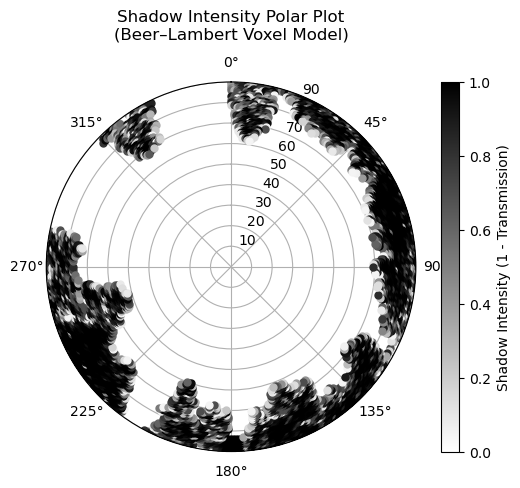

In [23]:
from shadow_model.visual_utils import *

altitude_range = np.arange(0, 90, 1)
azimuth_range = np.arange(0, 360, 1)

plot_shadow_polar(shadow_matrix_df.values, altitude_range, azimuth_range)

In [ ]:
# --- PV Forecast Comparison Plotter ---
#
# This script generates a single plot comparing the performance of different
# PV forecast models against the measured, real-world power output for a
# user-selected day.
#
# The plot will show four distinct time series:
# 1. Real PV Output: The actual, measured power generation.
# 2. Clear-Sky Prediction: The ideal forecast with no shadow correction.
# 3. Direct Version Forecast: The forecast corrected by a direct, single-point
#    lookup in the shadow matrix.
# 4. Windowed Version Forecast: The forecast corrected by averaging a small
#    area ("box blur") of the shadow matrix.

import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt

# Import the project's modules
import miniPVforecast
import shadowmap
import csv_reader

# --- CONFIGURATION ---
# --- Select the day you want to plot here ---
DAY_TO_PLOT = datetime(2021, 6, 9)

# --- Path to the shadow matrix to use for the forecast ---
# This should point to your best-performing, calibrated matrix.
SHADOW_MATRIX_PATH = 'results/shadow_matrix_results/shadow_attenuation_matrix_conecasting_f.csv'

# --- Define the radius for the "windowed" version ---
WINDOW_RADIUS = 20



def generate_comparison_plot(day_to_plot):

    # feeding parameters to pvmodel
    tilt = 12
    azimuth = 170
    longitude = 27.648656
    latitude = 62.979848

    miniPVforecast.tilt = tilt
    miniPVforecast.azimuth = azimuth
    miniPVforecast.longitude = longitude
    miniPVforecast.latitude = latitude
    miniPVforecast.rated_power = 3.960 * 0.81
    """
    Main function to load data, run models, and generate the plot.
    """
    print(f"--- Generating forecast comparison plot for {day_to_plot.date()} ---")
    start_time = time.time()
    
    # --- 1. Load Data ---
    
    # Temporarily modify csv_reader to load the correct matrix and fix the index
    original_get_shadowdata = csv_reader.get_shadowdata
    def load_and_fix_shadow_matrix(dense=True):
        print(f"Loading shadow matrix: {SHADOW_MATRIX_PATH}")
        df = pd.read_csv(SHADOW_MATRIX_PATH, index_col=0)
        df.index = df.index.str.replace('Altitude_', '').astype(int)
        return df
    csv_reader.get_shadowdata = load_and_fix_shadow_matrix
    
    print("Loading historical PV data...")
    full_pv_data = csv_reader.get_year(day_to_plot.year)
    
    # Get the measured data for the selected day
    time_end = day_to_plot + pd.Timedelta(days=1)
    pv_data_for_day = full_pv_data[(full_pv_data.index >= day_to_plot) & (full_pv_data.index < time_end)].copy()

    # time_end =  time_start + timedelta(days=dayrange)#datetime(2021, 10, 5)

    # df = df[(df.index >= time_start) & (df.index <= time_end)]
    
    if pv_data_for_day.empty:
        print(f"Error: No PV data found for {day_to_plot.date()}.")
        return

    # --- 2. Calculate the Four Data Series ---

    # Series 1: Real PV Output
    real_pv_output = pv_data_for_day["Energia MPP1 | Symo 8.2-3-M (1)"]

    # Series 2: Clear-Sky Prediction
    clearsky_forecast = miniPVforecast.get_pvlib_cleasky_irradiance(pv_data_for_day.index)

    # Prepare for shadow models
    azimuths, zeniths = miniPVforecast.get_solar_azimuth_zenit_fast(pv_data_for_day.index)
    pv_data_for_day["azimuth"] = azimuths
    pv_data_for_day["zenith"] = zeniths
    
    # Series 3: Direct Version Forecast (radius=0)
    pv_data_for_day["shading_direct"] = shadowmap.add_box_blur_shading_to_pv_output_df(pv_data_for_day, radius=0, max=False)
    direct_forecast = miniPVforecast.get_pvlib_shaded_clearsky_irradiance(pv_data_for_day.index, pv_data_for_day["shading_direct"])

    # Series 4: Windowed Version Forecast (radius=WINDOW_RADIUS)
    pv_data_for_day["shading_blur"] = shadowmap.add_box_blur_shading_to_pv_output_df(pv_data_for_day, radius=WINDOW_RADIUS, max=False)
    windowed_forecast = miniPVforecast.get_pvlib_shaded_clearsky_irradiance(pv_data_for_day.index, pv_data_for_day["shading_blur"])

    # Restore original csv_reader function
    csv_reader.get_shadowdata = original_get_shadowdata

    # --- 3. Plot the Results ---
    
    print("Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot each series with distinct styles
    ax.plot(real_pv_output.index, real_pv_output, label='1. Real PV Output', color='black', linewidth=2.5, zorder=4)
    ax.plot(clearsky_forecast.index, clearsky_forecast['output'], label='2. Clear-Sky Prediction', color='red', linestyle='--', linewidth=2, zorder=1)
    ax.plot(direct_forecast.index, direct_forecast['output'], label='3. Direct Version Forecast', color='green', linestyle=':', linewidth=2, zorder=2)
    ax.plot(windowed_forecast.index, windowed_forecast['output'], label=f'4. Windowed Version (r={WINDOW_RADIUS})', color='deepskyblue', linestyle='-', linewidth=2, zorder=3)

    # Formatting
    ax.set_title(f'PV Forecast Model Comparison for {day_to_plot.date()}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Time of Day', fontsize=12)
    ax.set_ylabel('Power [W]', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(pv_data_for_day.index.min(), pv_data_for_day.index.max())
    ax.set_ylim(bottom=0)
    
    # Improve date formatting on x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.tight_layout()
    
    # Save the figure
    output_dir = "figures/comparison_plots"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    filename = f"forecast_comparison_{day_to_plot.strftime('%Y-%m-%d')}.png"
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=150)
    print(f"Plot saved to {output_path}")
    
    end_time = time.time()
    print(f"Script finished in {end_time - start_time:.2f} seconds.")
    
    plt.show()

In [28]:
generate_comparison_plot(datetime(2021, 5, 30))

--- Generating forecast comparison plot for 2021-05-30 ---
Loading historical PV data...


TypeError: '>=' not supported between instances of 'int' and 'datetime.datetime'

In [ ]:
if not os.path.exists(OUTPUT_DIRECTORY):
        os.makedirs(OUTPUT_DIRECTORY)
        
output_path = os.path.join(OUTPUT_DIRECTORY, "shadow_matrix_re.csv")
# Write to CSV without header or index
shadow_matrix_df = 1- shadow_matrix_df
shadow_matrix_df.to_csv(output_path)

In [ ]:
shadow_matrix_df